  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features20191119_withWISE.csv'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

features_paps = '../ZTF_data/paps_features_all_with_mean.pkl'
features_wise = '../ZTF_data/WISE_SDSS_data_20191119.csv'
class_output = '../ZTF_classifications/classification_unlabelled_set_with_TSvs5_20191119.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

In [3]:
alerceclasses = { 'TDE': "TDE",
                  'Nova': "CV/Nova",
                  'CV': "CV/Nova",
                  'SN Ia-91bg-like': "SNIa",
                  'SN Ia': "SNIa",
                  'SN Ia-91T-like': "SNIa",
                  'SN Ia-CSM': "SNIa",
                  'SN Ia-pec': "SNIa",
                  'SN Iax[02cx-like]': "SNIa",
                  'SN Ib': "SNIbc",
                  'SN Ib-Ca-rich': "SNIbc",
                  'SN Ib-pec': "SNIbc",
                  'SN Ib/c': "SNIbc",
                  'SN Ibn': "SNIbc",
                  'SN Ic': "SNIbc",
                  'SN Ic-BL': "SNIbc",
                  'SN Ic-pec': "SNIbc",
                  'SN IIb': "SNIIb",
                  'SN II': "SNII",
                  'SN II-pec' : "SNII",
                  'SN IIL': "SNII",
                  'SN IIP': "SNII",
                  'SN IIn': "SNIIn",
                  'SN IIn-pec': "SNIIn",
                  'SLSN-I': "SLSN",
                  'SLSN-II': "SLSN",
                  'AGN': "",
                  'QSO': "",
                  'Impostor-SN': "",
                  'Kilonova': "",
                  'ILRT': "",
                  'LBV': "",
                  'M dwarf': "",
                  'Varstar': "",
                  'Galaxy': "",
                  'SN': "",
                  'SN I': "",
                  'Unknown': ""}


def encode(y):
    return y.apply(lambda x: alerceclasses[x])

### reading the training set files 

In [4]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#df_wise = pd.read_csv(features_wise,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''

#df_detections = pd.read_pickle(detections_file)
'''
df_paps = pd.read_pickle(features_paps)
df_paps = df_paps.set_index('oid')
df_paps.paps_ratio_1=df_paps.paps_ratio_1.astype(float)
df_paps.paps_ratio_2=df_paps.paps_ratio_2.astype(float)
df_paps.paps_high_2=df_paps.paps_high_2.astype(float)
df_paps.paps_high_1=df_paps.paps_high_1.astype(float)
df_paps.paps_low_2=df_paps.paps_low_2.astype(float)
df_paps.paps_low_1=df_paps.paps_low_1.astype(float)

print(df_paps.dtypes)

df_paps = df_paps.replace([np.inf, -np.inf], np.nan)
df_paps.replace([-99], -999,inplace=True)
df_paps.fillna(-999,inplace=True)
print(np.max(df_paps['paps_ratio_2']))

'''

#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_labels.head())

170976
             classALeRCE          ra        dec               period  \
oid                                                                    
ZTF19aavdfaf     CV/Nova  323.746659  40.671826         NON PERIODIC   
ZTF19aaniokz     CV/Nova  306.822433  43.689485               0.0777   
ZTF18accatjz     CV/Nova  331.153495  53.506598                  NaN   
ZTF19aarfrrf     CV/Nova  271.876088  45.858938  0.19362100000000002   
ZTF19aarfrre     CV/Nova  271.876073  45.859003  0.19362100000000002   

                      source id_source class_source  separation_arcsec  
oid                                                                     
ZTF19aavdfaf  CVsJavierAbril  V630 Cyg           CV           0.556391  
ZTF19aaniokz  CVsJavierAbril  V503 Cyg           CV           1.159315  
ZTF18accatjz  CVsJavierAbril    IV Cep           CV           0.742104  
ZTF19aarfrrf  CVsJavierAbril    DQ Her           CV           0.157008  
ZTF19aarfrre  CVsJavierAbril    DQ Her           C

In [5]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
#df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'
#df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
#df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
#label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

#labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EA') | (labels['class_hierachical'] == 'EB/EW')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'
labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EB')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(170948,)


,class_original,class_hierachical
oid,,
ZTF19aavdfaf,CV/Nova,Stochastic
ZTF19aaniokz,CV/Nova,Stochastic
ZTF18accatjz,CV/Nova,Stochastic
ZTF19aarfrrf,CV/Nova,Stochastic
ZTF19aarfrre,CV/Nova,Stochastic


In [6]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df.head()

112045
112045
112045
112045


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,54.0,1.777661,1.0,6.0,0.611111,0.019231,0.469122,-2.518495,0.563044,0.054041,...,6.421510,6.025469,0.129630,0.187500,0.886667,0.983125,0.039,2.122,6.797622,4.675622
ZTF18aaavxnm,28.0,1.545494,1.0,1.0,0.107143,0.000000,1.098733,2.110676,0.569369,0.040964,...,9.510968,6.567360,0.678571,0.769231,0.810000,1.000000,0.439,1.925,4.709099,2.784099
ZTF18abmefme,50.0,1.741148,1.0,1.0,0.520000,0.000000,1.358764,-1.566153,0.813194,0.068374,...,3.444530,3.397257,0.440000,0.413043,0.918333,0.996042,0.168,2.829,4.799764,1.970764
ZTF17aabumpu,30.0,1.484850,1.0,1.0,0.166667,0.000000,0.000388,2.675668,2.922255,0.054713,...,4.392597,-0.795429,0.800000,0.666667,0.750000,0.790198,0.026,0.576,2.404230,1.828230
ZTF18aazmwvg,49.0,2.734478,1.0,2.0,0.428571,0.021277,0.001367,-3.255004,197.232789,0.101743,...,6.564860,6.794348,0.571429,0.655738,0.792857,0.980625,0.440,3.472,4.365933,0.893933


In [7]:
print(df.columns)

Index(['n_samples_1', 'Amplitude_1', 'AndersonDarling_1', 'Autocor_length_1',
       'Beyond1Std_1', 'Con_1', 'Eta_e_1', 'Gskew_1', 'MaxSlope_1',
       'Meanvariance_1',
       ...
       'paps_ratio_1', 'paps_ratio_2', 'positive_fraction_1',
       'positive_fraction_2', 'rb', 'sgscore1', 'W1-W2', 'W2-W3', 'r-W3',
       'r-W2'],
      dtype='object', length=136)


In [8]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

QSO 9035
AGN 2147
Blazar 912
CV/Nova 778
YSO 1447
SNIa 765
SNIbc 50
SNII 212
SLSN 20
EB 31964
DSCT 646
RRL 29506
Ceph 554
LPV 33004
RSCVn 756
Periodic-Other 249


  ### Defining functions to plot the confusion matrix and the feature importance

In [9]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
#X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
#X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
#X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

112045
112045
50940 37858 838


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [11]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,#rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9815252800214199
Balanced accuracy: 0.9855965230504377


[[ 9244    65   156]
 [    0   208     1]
 [  190     2 12543]]
Normalized confusion matrix


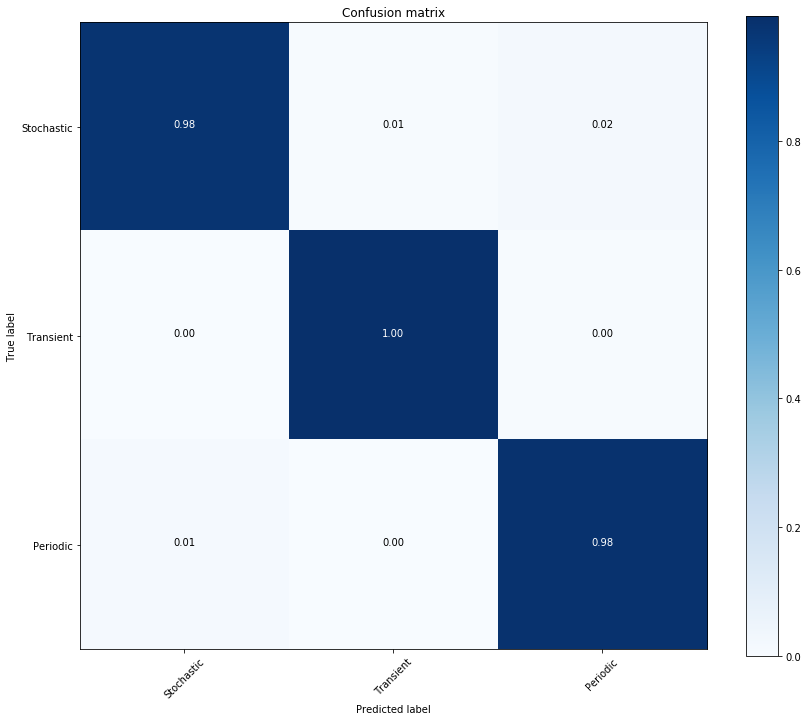

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

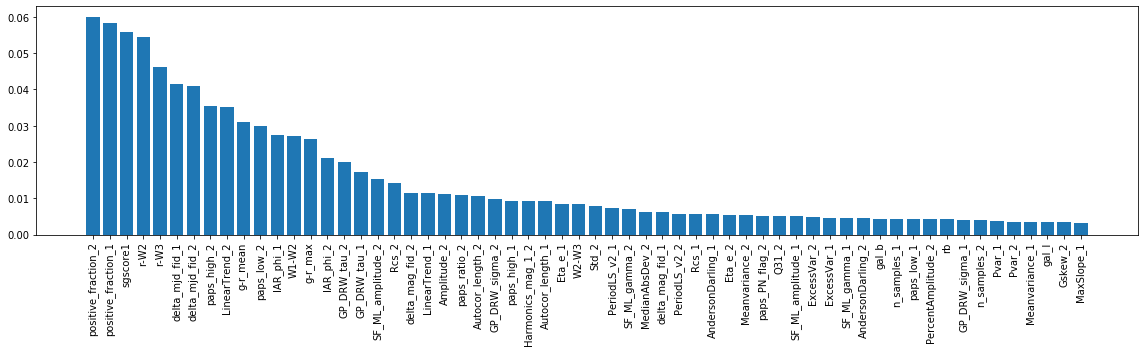

In [13]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [14]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL' 'RSCVn']


82


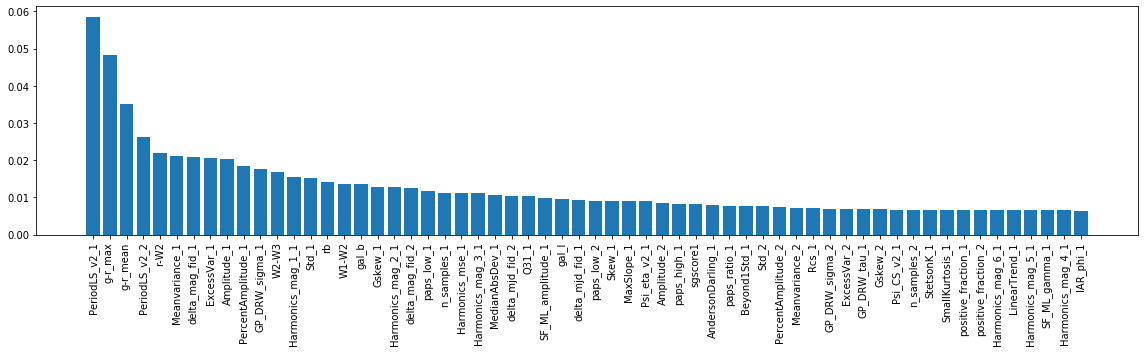

In [15]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [16]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO']


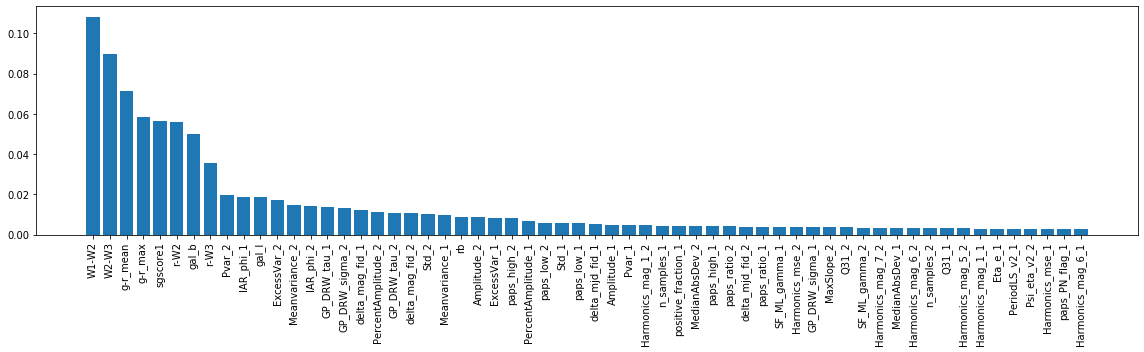

In [17]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [18]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


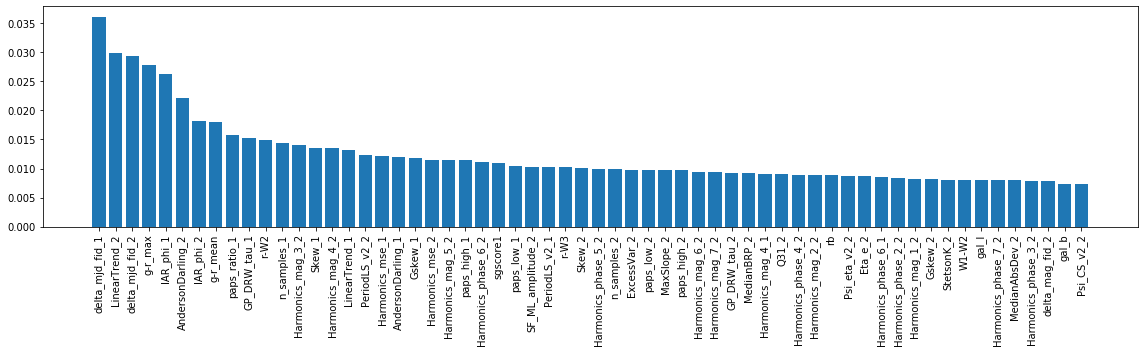

In [19]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [20]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 6.66784170201521e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL' 'RSCVn']


[[1515  197   73    1    3    0    0    1    5    0    0    0    0    0
     0   12]
 [  38  348   25    2    1    1    3    4    7    0    0    0    0    0
     0    1]
 [  22   16  136    3    0    0    1    0    1    0    0    1    0    0
     0    2]
 [   1    0    1   95    6    9    1    1    0    2   10   19    2    2
     3    4]
 [   0    2    6    1  249    0    0    0    0    1    0    3    3    8
    11    5]
 [   0    0    0    0    0  109   32    9    3    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    5    4    0    1    0    0    0    0    0
     0    0]
 [   0    1    0    0    0   10    5    8   17    0    0    0    0    0
     0    1]
 [   0    0    0    0    0    0    2    0    2    0    0    0    0    0
     0    0]
 [   9    4    1   64   40    0    0    0    0 3670  660  190  236   47
   546  926]
 [   0    0    0    1    0    0    0    0    0    4  115    4    0    1
     2    2]
 [  11   14    3   54   15    0    0    0    1  178  451 4499  13

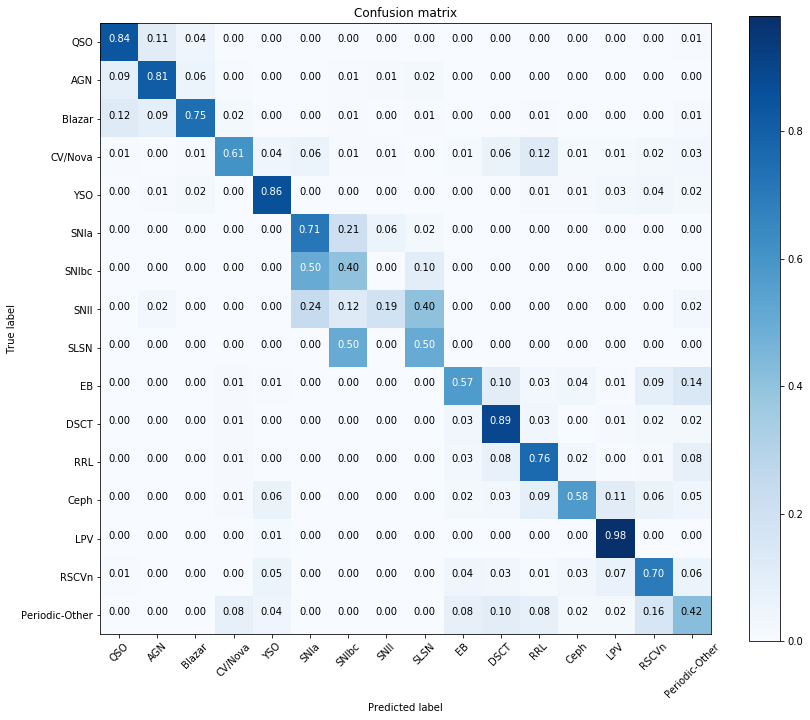

In [21]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("weighted precision: ", metrics.precision_score(y_test_original, class_final_name, average='weighted'))
print("weighted F1: ", metrics.f1_score(y_test_original, class_final_name, average='weighted'))



In [22]:
# Kaggle score

num_y_test =  class_final_index#[np.where(label_order==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[0.7750760929717764, 3.2571220930232556, 7.695398351648351, 8.977964743589743, 4.846237024221454, 9.154003267973856, 140.05625, 33.34672619047619, 350.140625, 0.21907750664789613, 10.857073643410853, 0.23734324690730385, 12.61768018018018, 0.21217429177397365, 9.27524834437086, 28.01125]
QSO -0.049107529912265614
AGN -0.05029482406407815
Blazar -0.08044966087557429
CV/Nova -0.014400387612564788
YSO -0.03112565320859574
SNIa -0.04802885203495827
SNIbc -0.06939580389399258
SNII -0.08908155777090586
SLSN -0.06129731966207303
EB -0.07154759900019968
DSCT -0.06828114940328121
RRL -0.07302824467992589
Ceph -0.05832396865907441
LPV -0.07641322043694464
RSCVn -0.040533191186117166
Periodic-Other -0.06621735508378439
0.9475263174843357


In [23]:
#print(class_final_name)

df_test = labels.join(X_test_hierarchical[['n_samples_1','n_samples_2']],how='right')

df_test = df_test.join(df_feat[['Mean_1','Mean_2']],how='left')

df_test['predicted_class'] = class_final_name

df_test_1band = df_test.loc[(df_test['n_samples_1']<6) | (df_test['n_samples_2']<6)]

df_test_2band = df_test.loc[(df_test['n_samples_1']>=6) & (df_test['n_samples_2']>=6)]

print(df_test_2band.head())

             class_original class_hierachical  n_samples_1  n_samples_2  \
oid                                                                       
ZTF18abfhjvn            LPV        Stochastic         18.0         44.0   
ZTF18achhdsf            QSO        Stochastic         46.0         19.0   
ZTF18ablvxxk            RRL          Periodic         54.0         56.0   
ZTF18abehjva            LPV        Stochastic         59.0         61.0   
ZTF17aacnsyp             EB          Periodic         23.0         18.0   

                 Mean_1     Mean_2 predicted_class  
oid                                                 
ZTF18abfhjvn  18.984053  15.659058             LPV  
ZTF18achhdsf  18.614515  18.371691             QSO  
ZTF18ablvxxk  18.095084  18.083291             RRL  
ZTF18abehjva  18.115926  15.687639             LPV  
ZTF17aacnsyp  14.442326  14.196989             RRL  


[0.7        0.455      0.80732177 0.65528455 0.84978992 0.65229885
 0.65648148 0.52627451 0.68066701 0.67127278 0.5487116  0.73548872
 0.69012519 0.89848485 0.71933622 0.74068699 0.75       0.83333333
 0.25      ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Balanced Accuracy')

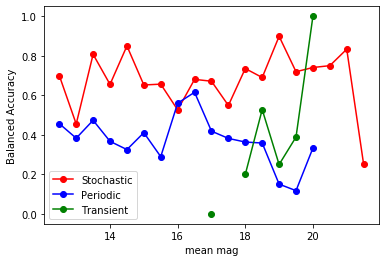

In [24]:
bins_mag = np.arange(12.5,22,0.5)
bins_nsamp_1band = np.arange(20,501,20)
bins_nsamp_2band = np.arange(20,831,20)

#1 band
acc_mag_1band_stochastic=[]
acc_mag_1band_periodic=[]
acc_mag_1band_transient=[]

for i in range(len(bins_mag)):
    df_test_1band_aux = df_test_1band[((df_test_1band['Mean_1']>=(bins_mag[i]-0.25)) & (df_test_1band['Mean_1']<(bins_mag[i]+0.25))) | ((df_test_1band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_1band['Mean_2']<(bins_mag[i]+0.25)))]
    
    #stochastics:
    df_test_1band_aux_stochastic = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_1band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_1band_aux_stochastic['predicted_class'].values
    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
    acc_mag_1band_stochastic.append(acc_stochastic)
    
    #periodics
    df_test_1band_aux_periodic = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_1band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_1band_aux_periodic['predicted_class'].values
    acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
    acc_mag_1band_periodic.append(acc_periodic)
    
    #transients
    df_test_1band_aux_transient = df_test_1band_aux[df_test_1band_aux['class_hierachical']=='Transient']
    true_y_transient = df_test_1band_aux_transient['class_original'].values
    pred_y_transient = df_test_1band_aux_transient['predicted_class'].values
    acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
    acc_mag_1band_transient.append(acc_transient)

acc_mag_1band_stochastic=np.array(acc_mag_1band_stochastic)
acc_mag_1band_periodic=np.array(acc_mag_1band_periodic)
acc_mag_1band_transient=np.array(acc_mag_1band_transient)

print(acc_mag_1band_stochastic)



plt.plot(bins_mag,acc_mag_1band_stochastic,'ro-',label='Stochastic')
plt.plot(bins_mag,acc_mag_1band_periodic,'bo-',label='Periodic')
plt.plot(bins_mag,acc_mag_1band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('mean mag')
plt.ylabel('Balanced Accuracy')

0 12.5
0 13.0
0 13.5
0 14.0
0 14.5
0 15.0
1 15.5
0 16.0
4 16.5
3 17.0
7 17.5
24 18.0
40 18.5
49 19.0
11 19.5
0 20.0
0 20.5
0 21.0
0 21.5
[0.7        0.455      0.80732177 0.65528455 0.84978992 0.65229885
 0.65648148 0.52627451 0.68066701 0.67127278 0.5487116  0.73548872
 0.69012519 0.89848485 0.71933622 0.74068699 0.75       0.83333333
 0.25      ]


Text(0, 0.5, 'Balanced Accuracy')

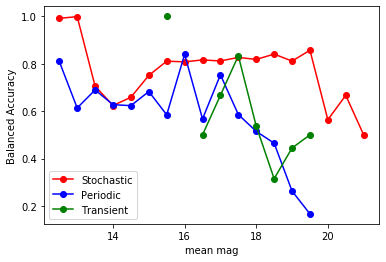

In [25]:
#2 bands
acc_mag_2band_stochastic=[]
acc_mag_2band_periodic=[]
acc_mag_2band_transient=[]

mag_2band_stochastic=[]
mag_2band_periodic=[]
mag_2band_transient=[]

for i in range(len(bins_mag)):
    df_test_2band_aux = df_test_2band[((df_test_2band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_2band['Mean_2']<(bins_mag[i]+0.25)))]
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
    acc_mag_2band_stochastic.append(acc_stochastic)
    
    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
    acc_mag_2band_periodic.append(acc_periodic)
    
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    print(len(df_test_2band_aux_transient['n_samples_1'].values),bins_mag[i])
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
    acc_mag_2band_transient.append(acc_transient)

acc_mag_2band_stochastic=np.array(acc_mag_2band_stochastic)
acc_mag_2band_periodic=np.array(acc_mag_2band_periodic)
acc_mag_2band_transient=np.array(acc_mag_2band_transient)

print(acc_mag_1band_stochastic)

plt.plot(bins_mag,acc_mag_2band_stochastic,'ro-',label='Stochastic')
plt.plot(bins_mag,acc_mag_2band_periodic,'bo-',label='Periodic')
plt.plot(bins_mag,acc_mag_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('mean mag')
plt.ylabel('Balanced Accuracy')

4102 20
4288 40
2476 60
1414 80
926 100
591 120
395 140
299 160
242 180
160 200
155 220
100 240
71 260
51 280
45 300
32 320
29 340
18 360
15 380
11 400
6 420
5 440
5 460
1 480
1 500
1 520
4 540
1 560
2 580
1 600
2 620
2 640
1 660
2 680
1 700
0 720
1 740
1 760
0 780
0 800
0 820


Text(0, 0.5, 'Balanced Accuracy')

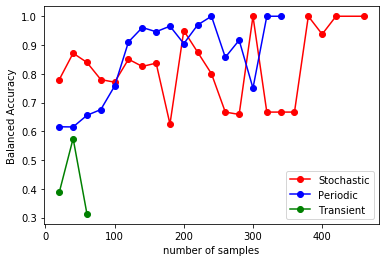

In [26]:
#2 bands
acc_nsamp_2band_stochastic=[]
acc_nsamp_2band_periodic=[]
acc_nsamp_2band_transient=[]

nsamp_2band_stochastic=[]
nsamp_2band_periodic=[]
nsamp_2band_transient=[]

for i in range(len(bins_nsamp_2band)):
    df_test_2band_aux = df_test_2band[(((df_test_2band['n_samples_1'].values+df_test_2band['n_samples_2'].values)>=(bins_nsamp_2band[i]-10)) & ((df_test_2band['n_samples_1'].values+df_test_2band['n_samples_2'].values)<(bins_nsamp_2band[i]+10)))]
    print(len(df_test_2band_aux['n_samples_1'].values),bins_nsamp_2band[i])
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    if (len(pred_y_stochastic))>4:
        acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
        acc_nsamp_2band_stochastic.append(acc_stochastic)
        nsamp_2band_stochastic.append(bins_nsamp_2band[i])

    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    if (len(pred_y_periodic))>4:
        acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
        acc_nsamp_2band_periodic.append(acc_periodic)
        nsamp_2band_periodic.append(bins_nsamp_2band[i])
        
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    if (len(pred_y_transient))>4:
        acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
        acc_nsamp_2band_transient.append(acc_transient)
        nsamp_2band_transient.append(bins_nsamp_2band[i])

acc_nsamp_2band_stochastic=np.array(acc_nsamp_2band_stochastic)
acc_nsamp_2band_periodic=np.array(acc_nsamp_2band_periodic)
acc_nsamp_2band_transient=np.array(acc_nsamp_2band_transient)

nsamp_2band_stochastic=np.array(nsamp_2band_stochastic)
nsamp_2band_periodic=np.array(nsamp_2band_periodic)
nsamp_2band_transient=np.array(nsamp_2band_transient)



plt.plot(nsamp_2band_stochastic,acc_nsamp_2band_stochastic,'ro-',label='Stochastic')
plt.plot(nsamp_2band_periodic,acc_nsamp_2band_periodic,'bo-',label='Periodic')
plt.plot(nsamp_2band_transient,acc_nsamp_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('number of samples')
plt.ylabel('Balanced Accuracy')

  ## Analysis post classification in training set

In [27]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


             class_original pred_class
oid                                   
ZTF18abfhjvn            LPV        LPV
ZTF19aaqeiit            QSO        QSO
ZTF18acdnspc             EB      RSCVn
ZTF18achhdsf            QSO        QSO
ZTF17aabwqjg             EB       DSCT
[]
Empty DataFrame
Columns: [n_samples_1, Amplitude_1, AndersonDarling_1, Autocor_length_1, Beyond1Std_1, Con_1, Eta_e_1, Gskew_1, MaxSlope_1, Meanvariance_1, MedianAbsDev_1, MedianBRP_1, PairSlopeTrend_1, PercentAmplitude_1, Q31_1, PeriodLS_v2_1, Period_fit_v2_1, Psi_CS_v2_1, Psi_eta_v2_1, Rcs_1, Skew_1, SmallKurtosis_1, Std_1, StetsonK_1, Harmonics_mag_1_1, Harmonics_mag_2_1, Harmonics_mag_3_1, Harmonics_mag_4_1, Harmonics_mag_5_1, Harmonics_mag_6_1, Harmonics_mag_7_1, Harmonics_phase_2_1, Harmonics_phase_3_1, Harmonics_phase_4_1, Harmonics_phase_5_1, Harmonics_phase_6_1, Harmonics_phase_7_1, Harmonics_mse_1, Pvar_1, ExcessVar_1, SF_ML_amplitude_1, SF_ML_gamma_1, GP_DRW_sigma_1, GP_DRW_tau_1, IAR_phi_1, LinearTrend_

In [28]:
'''
import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);
'''

'\nimport psycopg2\nimport json\n\ncredentials_file = "alercereaduser.json"\nwith open(credentials_file) as jsonfile:\n    params = json.load(jsonfile)["params"]\n    \n\nconn = psycopg2.connect(dbname=params[\'dbname\'], user=params[\'user\'], host=params[\'host\'], password=params[\'password\'])\n    \n    \ndef plotLC(oid, SN_det, SN_nondet):\n    fig, ax = plt.subplots(figsize = (10, 5))\n    labels = {1: \'g\', 2: \'r\'}\n    colors = {1: \'g\', 2: \'r\'}\n    for fid in [1, 2]:\n        mask = SN_det.fid == fid\n        if np.sum(mask) > 0:            \n            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, \n                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = \'o\', label = labels[fid])\n        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)\n        #if np.sum(mask) > 0:            \n        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,\n        #        marker = \'v\', label 

  ## Classifying unlabeled data

In [29]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

if extragalactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b > 20) | (df_feat_ul.gal_b < -20)]

if galactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b <= 20) & (df_feat_ul.gal_b >= -20)]
    
if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_samples_1 > 5) & (df_feat_ul.n_samples_2 > 5)]
    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()


653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [30]:
#predicting classes of unlabeled data


test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 6.508943177067425e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL' 'RSCVn']


In [31]:
#Writing results in the output

df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''
test_data_withclass.head()

(653905, 159)
653905
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,...,z,u_g,g_r,r_i,i_z,W2-W3,r-W3,r-W2,predicted_class,predicted_class_proba
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.89464,2.00695,0.9466,0.37879,0.31268,0.912,2.997933,2.085933,RSCVn,0.374028
ZTF17aaaaaam,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-999.00000,-999.00000,-999.0000,-999.00000,-999.00000,0.565,5.909550,5.344550,YSO,0.453600
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,16.564657,...,-999.00000,-999.00000,-999.0000,-999.00000,-999.00000,0.893,3.745013,2.852013,EB,0.369260
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,17.022176,...,-999.00000,-999.00000,-999.0000,-999.00000,-999.00000,1.623,4.135574,2.512574,EB,0.383344
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,17.329499,...,-999.00000,-999.00000,-999.0000,-999.00000,-999.00000,1.001,4.327510,3.326510,EB,0.264928


In [32]:
test_data_withclass.shape

(653905, 161)

Text(0.5, 1.0, 'sources classified')

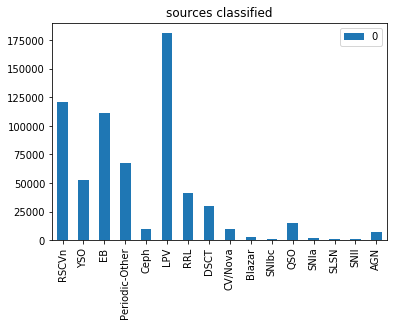

In [33]:
letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


0 AGN 0.44753600000000004
1 Blazar 0.40291599999999994
2 CV/Nova 0.20700000000000002
3 LPV 0.725532
4 QSO 0.6365
5 YSO 0.348772
6 SLSN 0.29526199999999997
7 SNII 0.263056
8 SNIa 0.37026
9 SNIbc 0.306124
10 Ceph 0.295408
11 DSCT 0.280852
12 EB 0.357216
13 Periodic-Other 0.293724
14 RRL 0.45456799999999997
15 RSCVn 0.362464


Text(0.5, 0, 'predicted probability ($P_{HRF}$)')

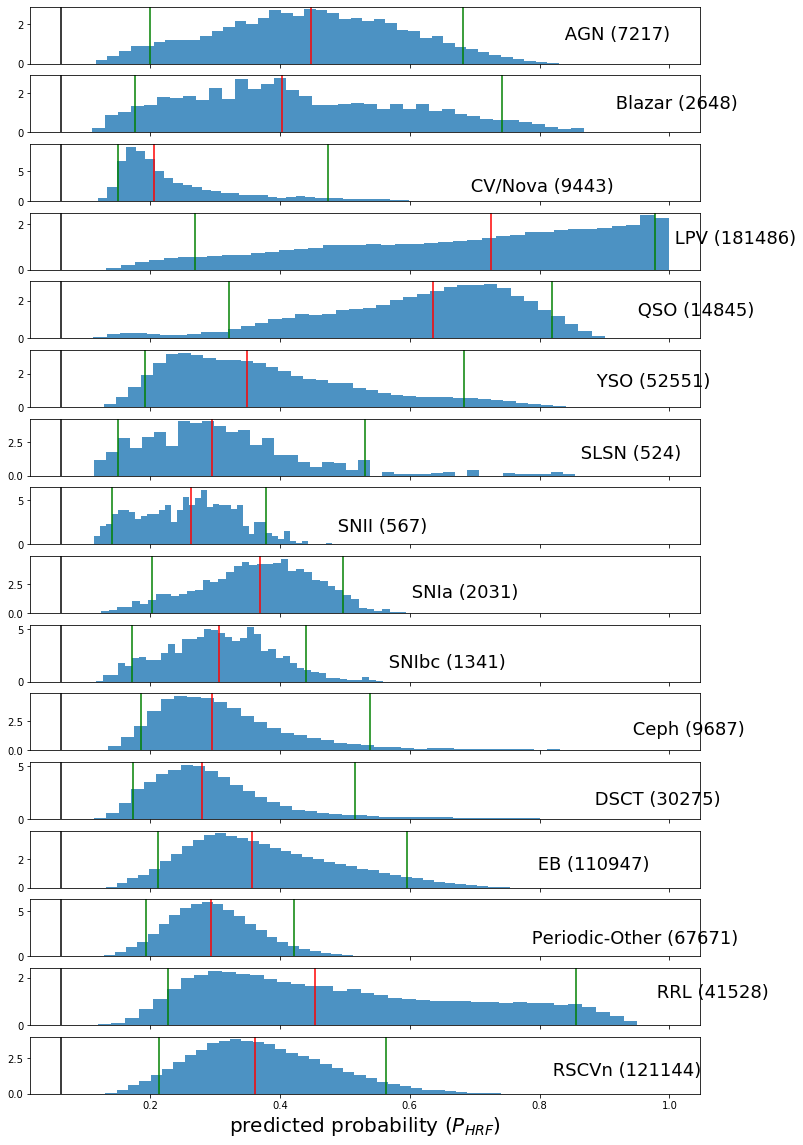

In [34]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')
    
ax[len(label_order)-1].set_xlabel(r'predicted probability ($P_{HRF}$)',fontsize=20)      

0 QSO 0.1147390363563936
1 AGN 0.15682017322190234
2 Blazar 0.3936305181058977
3 CV/Nova -0.026105408408150232
4 YSO 1.4929138025276991
5 SNIa 0.012903213500999655
6 SNIbc 0.4346666336059499
7 SNII 0.18158149719244854
8 SLSN 0.1410846710205007
9 EB 0.5516843455213998
10 DSCT 0.03726910503009862
11 RRL 0.0597758390740033
12 Ceph 0.8106114448345991
13 LPV 2.2658786149634977
14 RSCVn 0.8967385232569995
15 Periodic-Other 0.4875497713696007


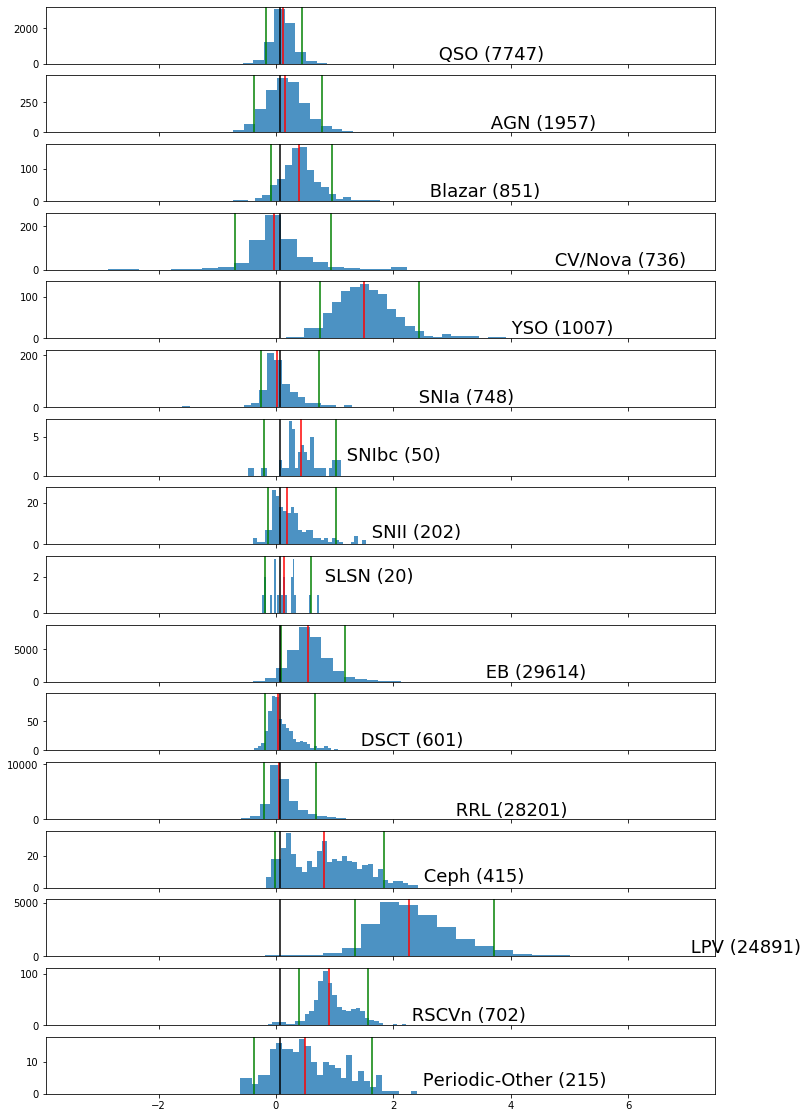

In [35]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

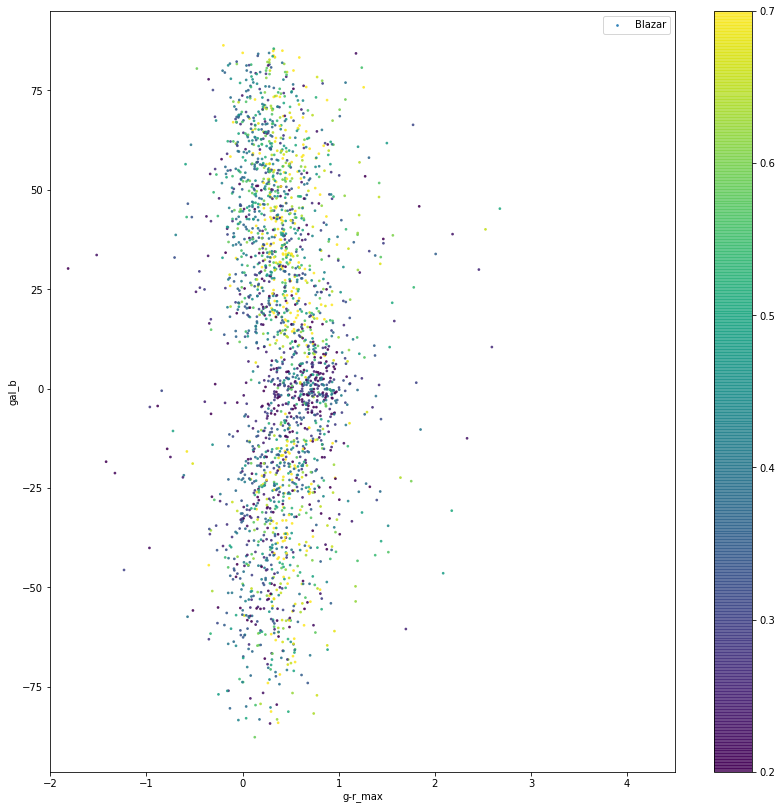

In [40]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
#labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']#,'LPV']
labels_list = ['Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,4.5)

cm = plt.cm.get_cmap('viridis')

for idx, cl in enumerate(labels_list):
   #print(idx, cl)c=t
   #ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 3,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)

plt.colorbar(sc)

plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

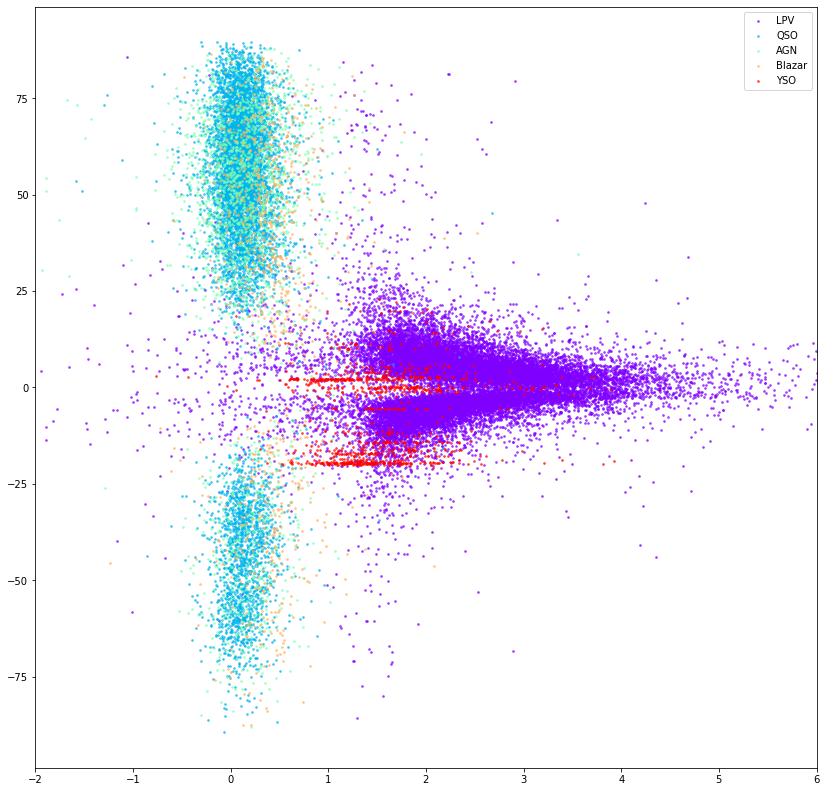

In [37]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

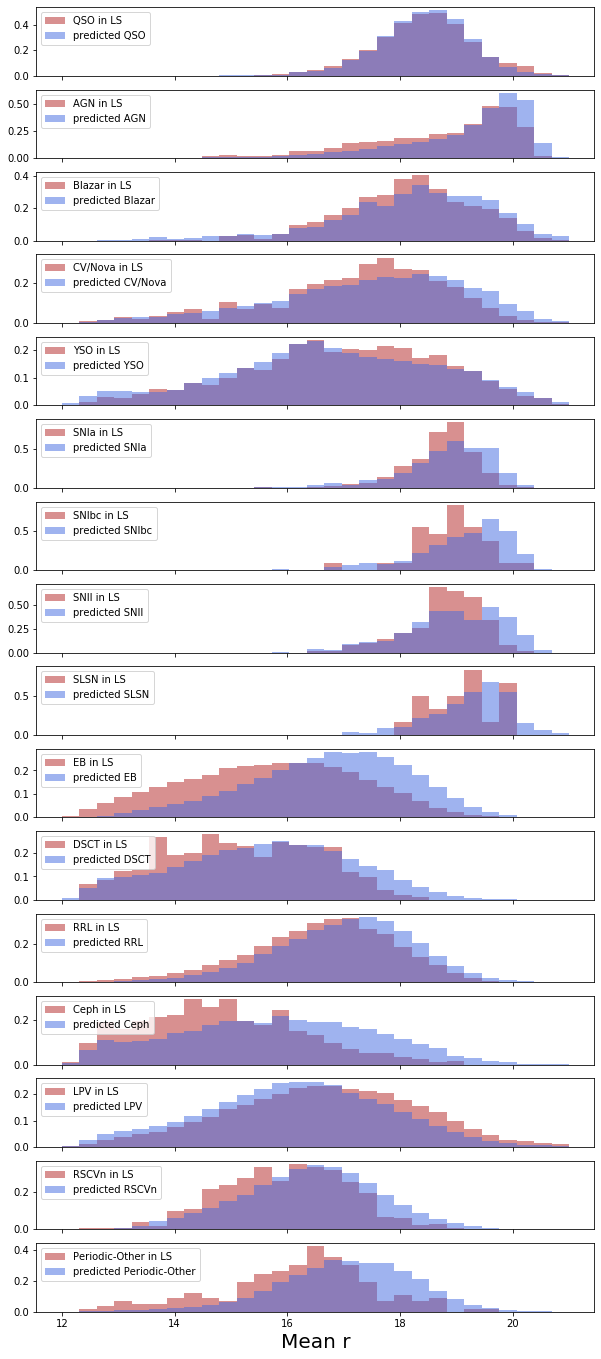

In [38]:

feature = 'Mean_1'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(10, 24), sharex=True)

bins_hist = np.linspace(12,21,30)

for idx, cl in enumerate(label_order):
   
   ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "firebrick", ec=None,label=cl+' in LS', alpha=0.5)
   ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "royalblue", ec=None,label='predicted '+cl, alpha=0.5)
   ax[idx].legend(loc='upper left')

ax[len(label_order)-1].set_xlabel('Mean r',fontsize=20)    
plt.savefig('/Users/psanchez/Desktop/Rband_dist.pdf')





[9.52957756e-01 4.23006301e-13 5.79546521e-01 ... 8.37232051e-03
 5.37975663e-04 8.41459882e-03]


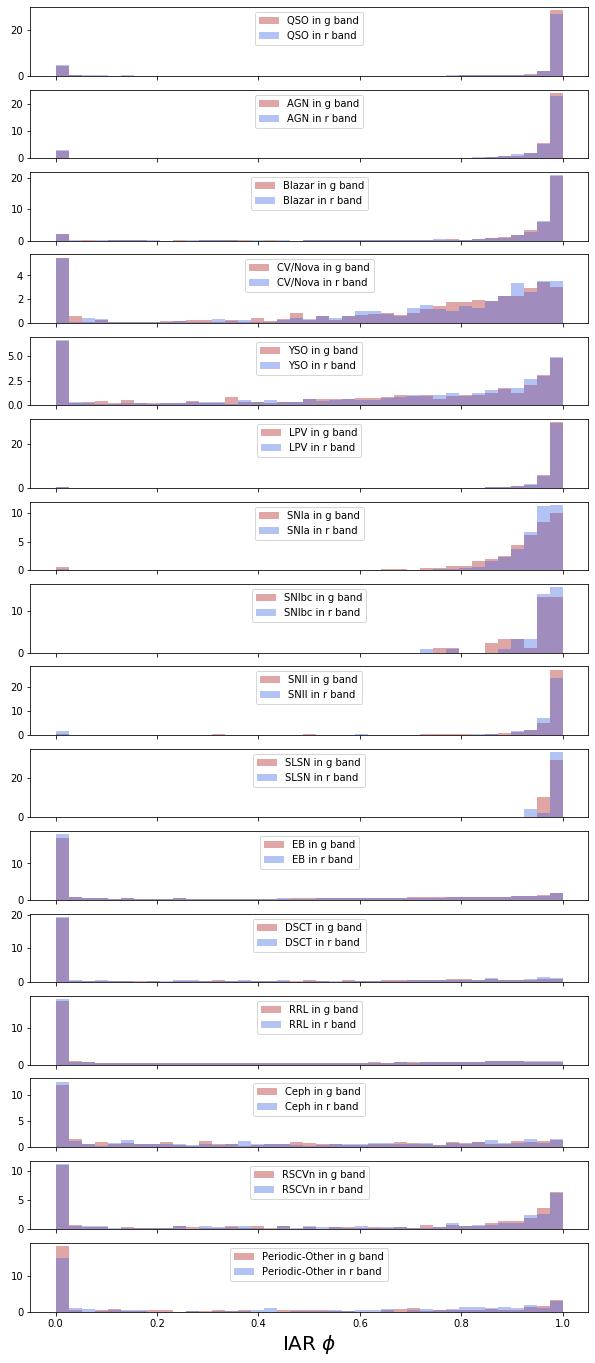

In [39]:
feature1 = 'IAR_phi_1'
feature2 = 'IAR_phi_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot1 = df_train_plot.loc[df_train_plot[feature1]>-999] 
df_train_plot2 = df_train_plot.loc[df_train_plot[feature2]>-999] 

print(df_train_plot2[feature2].values)
#label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']
label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']

fig, ax = plt.subplots(nrows = len(label_order_aux), figsize=(10, 24), sharex=True)

bins_hist = np.linspace(0,1.0001,40)

for idx, cl in enumerate(label_order_aux):
   
   ax[idx].hist(df_train_plot1[feature1][df_train_plot1['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "firebrick", ec=None,label=cl+' in g band', alpha=0.4)
   ax[idx].hist(df_train_plot2[feature2][df_train_plot2['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "royalblue", ec=None,label=cl+' in r band', alpha=0.4)
   ax[idx].legend(loc='upper center')

ax[len(label_order)-1].set_xlabel(r'IAR $\phi$',fontsize=20)    
plt.savefig('/Users/psanchez/Desktop/IAR_dist.pdf')